### statis

In [2]:
from sys import getsizeof
import numpy as np

In [4]:
test = ("abc", "abbiodwfbewofewfnq", "absadfqw")
getsizeof(test)

64

In [6]:
test = np.array(("abc", "abbiodwfbewofewfnq", "absadfqw"))
getsizeof(test)

328

In [3]:
import json

In [28]:
def save_data(path, data):
    with open(path, "w", encoding="utf-8") as f:
        for sample in data:
            json_obj = json.dumps(sample, ensure_ascii=False)
            f.write(json_obj+"\n")

In [31]:
path = "/home/tuyendv/Desktop/reranker/data/raw/squad-train-v2.0-en.json"
data = json.load(open(path))

In [32]:
msmacro_data = []
for text in data["data"]:
    for paragraph in text["paragraphs"]:
        passage = paragraph["context"]
        for sample in paragraph["qas"]:
            query = sample["question"]
            
            _temp = {
                "query": query,
                "passage": passage
            }
            msmacro_data.append(_temp)

In [33]:
save_data("/home/tuyendv/Desktop/reranker/data/ir/train/squad-train-v2.0-en.json", msmacro_data)

### vi_squad

In [38]:
%cd /home/tuyendv/Desktop/reranker
import json
import pandas as pd
from bm25 import BM25
from tqdm import tqdm
from utils import save_data, load_file

/home/tuyendv/Desktop/reranker


In [44]:
path = "/home/tuyendv/Desktop/reranker/data/raw/squad-train-v2.0-en.json"
data = load_file(path)

df = pd.DataFrame(data, columns=["passage", "query", "answer"])
df.head()

,passage,query,answer
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,NaN
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,NaN
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,NaN
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,NaN
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,NaN


In [45]:
passages = []
for i, doc in enumerate(df.passage.unique().tolist()):
    _id = str(i).zfill(6)
    _text = doc
    
    passages.append([_id, _text])
    
passages = pd.DataFrame(passages, columns=["id", "passage_text"])
passages.head()

,id,passage_text
0,000000,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
1,000001,Following the disbandment of Destiny's Child i...
2,000002,"A self-described ""modern-day feminist"", Beyonc..."
3,000003,"Beyoncé Giselle Knowles was born in Houston, T..."
4,000004,Beyoncé attended St. Mary's Elementary School ...


In [46]:
bm25 = BM25()
bm25.train(passages)

In [47]:
data = []
for index in tqdm(df.index):
    query = df["query"][index]
    positive_passage = df["passage"][index]
    all_passage = bm25.ranking(positive_passage, top_k=8)["retrieval_text"].tolist()
    
    passages = []
    mark = 0
    for passage in all_passage:
        if positive_passage == passage:
            sample = {
                "is_selected":1,
                "passage_text":passage
            }
            mark = 1
        else:
            sample = {
                "is_selected":0,
                "passage_text":passage
            }
        passages.append(sample)
        
    if mark == 0:
        sample = {
            "is_selected":1,
            "passage_text":positive_passage
        }
        passages.append(sample)
    
    data.append(
        {
            "query":query,
            "passages":passages
        }
    )

100%|██████████| 130319/130319 [23:09<00:00, 93.81it/s] 


In [48]:
path = "/home/tuyendv/Desktop/reranker/data/ir/train/squad-train-v2.0-en.json"
save_data(path, data=data)

### vi_data

In [ ]:
import pandas as pd
import json

In [ ]:
path = "/home/tuyendv/Desktop/reranker/data/raw/vi_data.json"
df = pd.read_json(path)
df.head()

In [ ]:
data = []
for index in df.index:
    query = df["question"][index]
    positive = df["positive_sample"][index]
    negative_samples = df["negative_samples"][index]
    
    passages = []
    
    passages.append(
        {
            "passage_text":positive,
            "is_selected":1
        }
    )
    
    for negative in negative_samples:
        passages.append(
            {
                "passage_text":negative,
                "is_selected":0
            }
        )
        
    data.append(
        {
            "query":query,
            "passages":passages
        }
    )

In [ ]:
def save_data(path, data):
    with open(path, "w", encoding="utf-8") as f:
        for sample in data:
            json_obj = json.dumps(sample, ensure_ascii=False)
            f.write(json_obj+"\n")

path="/home/tuyendv/Desktop/reranker/data/ir/vi_data.json"
save_data(path, data)

### v1

In [1]:
import json

In [5]:
path = "/home/tuyendv/Desktop/reranker/data/ir/train/ms-macro-train_v1.1.json"

data = []
with open(path, "r", encoding="utf-8") as f:
    for line in f.readlines():
        line = json.loads(line.strip())
        passages = [
            {
                "passage_text":i["passage_text"],
                "is_selected":i["is_selected"]
                } for i in line["passages"]
            ]
        data.append(
            {
                "query":line["query"],
                "passages":passages
            }
        )

In [4]:
def save_data(path, data):
    with open(path, "w", encoding="utf-8") as f:
        for sample in data:
            json_obj = json.dumps(sample, ensure_ascii=False)
            f.write(json_obj+"\n")

path = "/home/tuyendv/Desktop/reranker/data/ir/train/ms-macro-train_v1.1.json"
save_data(path, data[0:30000])

### process data

In [2]:
%cd /home/tuyendv/Desktop/reranker/
import json
import pandas as pd
from utils import load_file, load_data

/home/tuyendv/Desktop/reranker


In [3]:
path = '/home/tuyendv/Desktop/reranker/data/processed-ir-data/train'
data = load_data(path)

In [4]:
df = pd.DataFrame(data)
df.head()

,query,passages
0,does human hair stop squirrels,[{'passage_text': 'We have been feeding our ba...
1,what are the benefits of fossil fuels,[{'passage_text': 'The biggest advantage of us...
2,what is a apothem,[{'passage_text': 'Apothem. The apothem of a r...
3,average cost for custom canopy,[{'passage_text': 'Congratulations! You have f...
4,what is a hardware in a computer,[{'passage_text': 'Hardware is best described ...


In [5]:
def get_length(query, passages):
    query_length = len(query.split())
    
    lengths = []
    for pa in passages:
        tmp = pa["passage_text"]
        
        lengths.append(len(tmp.split()) + query_length)
        
    return lengths

df["length"] = df.apply(lambda x: get_length(x["query"], x["passages"]), axis=1)

In [6]:
df["num_pass"] = df.passages.apply(lambda x: len(x))
df.head()

,query,passages,length,num_pass
0,does human hair stop squirrels,[{'passage_text': 'We have been feeding our ba...,"[61, 59, 46, 62, 60, 65, 56]",7
1,what are the benefits of fossil fuels,[{'passage_text': 'The biggest advantage of us...,"[98, 64, 91, 120, 106, 91, 94, 117, 89]",9
2,what is a apothem,[{'passage_text': 'Apothem. The apothem of a r...,"[94, 40, 109, 39, 89, 111, 89, 81, 103]",9
3,average cost for custom canopy,[{'passage_text': 'Congratulations! You have f...,"[51, 73, 123, 87, 72, 114, 115, 108, 37]",9
4,what is a hardware in a computer,[{'passage_text': 'Hardware is best described ...,"[97, 70, 89, 58, 46, 89, 92, 106, 54, 40]",10


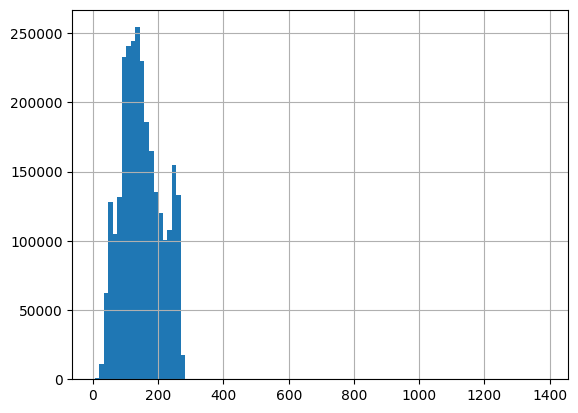

In [7]:
lengths = [i for j in df.length.tolist() for i in j]
pd.DataFrame(lengths, columns=["lengths"]).lengths.hist(bins=100)

### temp

In [1]:
%cd /home/tuyendv/Desktop/reranker/
import os 
from glob import glob
import json
import pandas as pd
from utils import load_data

/home/tuyendv/Desktop/reranker


In [2]:
path = "/home/tuyendv/Desktop/reranker/data/ir/test"
data = load_data(path)
data = [json.loads(line) for line in data]
len(data)

136

In [3]:
data= pd.DataFrame(data)
data.head()

,query,passages
0,Vingroup bị cáo buộc vi phạm những quy định n...,[{'passage_text': 'nhất (FPS) miễn phí được Ri...
1,VinFast LUX A2.0 được trưng bày ở đâu vào năm...,"[{'passage_text': 'tin tài sản nhanh chóng, ti..."
2,Cơ sở Technocom ở Ukraina có những nhà máy nào?,[{'passage_text': 'bảo chất lượng mạng Năm 200...
3,Đại hội cổ đông bất thường 2 Công ty Cổ phần ...,"[{'passage_text': 'như quản trị, quản lý hợp N..."
4,Tập đoàn Vingroup - Công ty CP (Vingroup) có ...,"[{'passage_text': 'Bắc, Trung, Nam có chức Năm..."


In [4]:
def get_length(query, passages):
    query_length = len(query.split())
    
    lengths = []
    for pa in passages:
        tmp = pa["passage_text"]
        
        lengths.append(len(tmp.split()) + query_length)
        
    return lengths

data["length"] = data.apply(lambda x: get_length(x["query"], x["passages"]), axis=1)

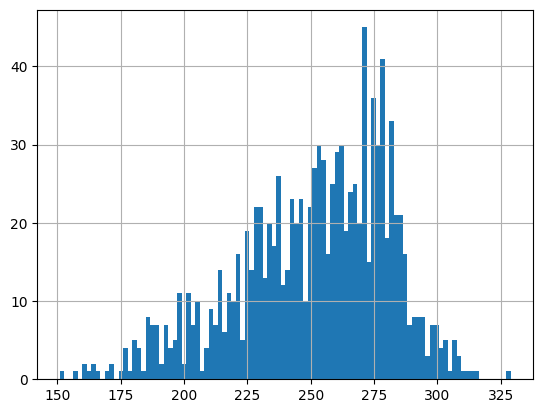

In [5]:
lengths = [i for j in data.length.tolist() for i in j]
pd.DataFrame(lengths, columns=["lengths"]).lengths.hist(bins=100)

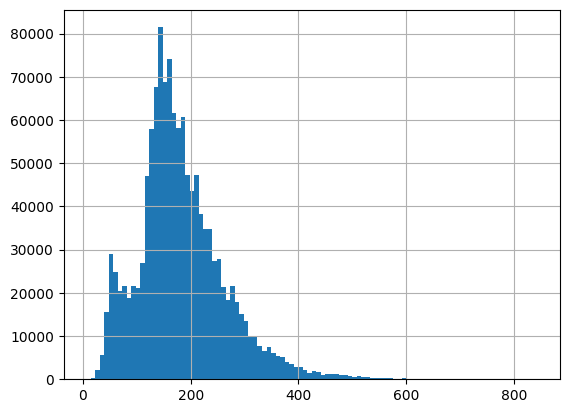

In [5]:
lengths = [i for j in data.length.tolist() for i in j]
pd.DataFrame(lengths, columns=["lengths"]).lengths.hist(bins=100)